In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
# Load files
retail = pd.read_csv("./output/Fed_DR.csv")
macro = pd.read_csv("./output/ccar_macro_data_quarterly.csv")

# Convert Date column
retail['Date'] = pd.to_datetime(retail['Quarter_dt'])
macro['Date'] = pd.to_datetime(macro['DATE'])

macro['Date'] = macro['Date'].dt.to_period('Q').dt.start_time

# Merge
df = pd.merge(retail, macro, on="Date", how="inner")

# Sort
df = df.sort_values("Date").reset_index(drop=True)

df

,Quarter_dt,Wholesale_Proxy_DR,Retail_Proxy_DR,Date,DATE,Unemployment_Rate,Real_GDP,BBB_Spread,VIX_Volatility_Index,10Y_Treasury_Yield,3M_Treasury_Rate,Prime_Rate,CPI_Inflation,Real_Disposable_Income,Real_GDP_Growth
0,2000-01-01,0.0191,0.0436,2000-01-01,2000-03-31,4.033333,13878.147,1.609077,23.150317,6.468413,5.520000,8.694444,170.100000,9833.933333,0.014512
1,2000-04-01,0.0208,0.0449,2000-04-01,2000-06-30,3.933333,14130.908,2.139231,24.923968,6.184921,5.713333,9.250000,171.433333,9950.166667,0.072852
2,2000-07-01,0.0218,0.0450,2000-07-01,2000-09-30,4.000000,14145.312,2.151515,19.169048,5.889841,6.016667,9.500000,173.000000,10081.500000,0.004077
3,2000-10-01,0.0237,0.0448,2000-10-01,2000-12-31,3.900000,14229.765,2.496923,26.016667,5.570645,6.016667,9.500000,174.233333,10149.000000,0.023882
4,2001-01-01,0.0259,0.0467,2001-01-01,2001-03-31,4.233333,14183.120,2.422154,25.726452,5.044194,4.816667,8.620968,175.900000,10229.833333,-0.013112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2024-07-01,0.0109,0.0308,2024-07-01,2024-09-30,4.166667,23478.570,1.198358,17.066667,3.954687,4.990000,8.437500,314.182667,17755.333333,0.032991
99,2024-10-01,0.0120,0.0297,2024-10-01,2024-12-31,4.133333,23586.542,1.032121,17.363231,4.275484,4.400000,7.823077,316.538667,17843.266667,0.018395
100,2025-01-01,0.0118,0.0293,2025-01-01,2025-03-31,4.133333,23548.210,1.060000,18.521111,4.453607,4.210000,7.500000,319.492000,17943.133333,-0.006501
101,2025-04-01,0.0118,0.0292,2025-04-01,2025-06-30,4.200000,23770.976,1.231231,23.561406,4.361774,4.230000,7.500000,320.800333,18025.300000,0.037840


In [4]:
## Create Dependent variable - Logit transform of DR

# Avoid log(0)
epsilon = 1e-6
df['DR_adj'] = df['Retail_Proxy_DR'].clip(epsilon, 1 - epsilon)

# Logit transform
df['logit_DR'] = np.log(df['DR_adj'] / (1 - df['DR_adj']))

In [5]:
## Create 1-quarter lagged macro variables

lag_vars = [
    'Unemployment_Rate',
    'CPI_Inflation',
    'Real_Disposable_Income',
    'Prime_Rate',
    'Real_GDP_Growth'
]

for var in lag_vars:
    df[f'{var}_lag1'] = df[var].shift(1)

# Lagged dependent variable (persistence)
df['logit_DR_lag1'] = df['logit_DR'].shift(1)

# Drop NA after lag
df = df.dropna().reset_index(drop=True)

In [6]:
X_vars = [
    'Unemployment_Rate_lag1',
    'CPI_Inflation_lag1',
    'Real_Disposable_Income_lag1',
    'Prime_Rate_lag1',
    'Real_GDP_Growth_lag1',
    'logit_DR_lag1'
]

X = df[X_vars]
X = sm.add_constant(X)

y = df['logit_DR']

In [7]:
## Multicollinearity check using VIF

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

print(vif_data)

                       Feature         VIF
0                        const  358.228808
1       Unemployment_Rate_lag1    2.672607
2           CPI_Inflation_lag1   15.989116
3  Real_Disposable_Income_lag1   18.437741
4              Prime_Rate_lag1    2.801949
5         Real_GDP_Growth_lag1    1.071792
6                logit_DR_lag1    3.666506


In [9]:
## Dropped Real_Disposable_Income_lag1 due to high VIF

X_vars = [
    'Unemployment_Rate_lag1',
    'CPI_Inflation_lag1',
    'Prime_Rate_lag1',
    'Real_GDP_Growth_lag1',
    'logit_DR_lag1'
]

X = df[X_vars]
X = sm.add_constant(X)
y = df['logit_DR']

vif_data_updated = pd.DataFrame()
vif_data_updated["Feature"] = X.columns
vif_data_updated["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

print(vif_data_updated)

                  Feature         VIF
0                   const  340.614606
1  Unemployment_Rate_lag1    2.626671
2      CPI_Inflation_lag1    2.058348
3         Prime_Rate_lag1    2.794000
4    Real_GDP_Growth_lag1    1.066171
5           logit_DR_lag1    3.166531


In [10]:
# Run Logistic Style Linear Regression (Logit OLS)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               logit_DR   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1042.
Date:                Fri, 27 Feb 2026   Prob (F-statistic):           5.92e-82
Time:                        16:52:09   Log-Likelihood:                 158.38
No. Observations:                 102   AIC:                            -304.8
Df Residuals:                      96   BIC:                            -289.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [12]:
## Modeling change instead of level as above model shows high persistence and is economically wrong

df['d_logit_DR'] = df['logit_DR'].diff()
df['d_Unemployment'] = df['Unemployment_Rate'].diff()
df['d_CPI'] = df['CPI_Inflation'].diff()
df['d_Prime'] = df['Prime_Rate'].diff()
df['d_GDP_Growth'] = df['Real_GDP_Growth'].diff()

# Lagging differenced variables
df['d_Unemployment_lag1'] = df['d_Unemployment'].shift(1)
df['d_CPI_lag1'] = df['d_CPI'].shift(1)
df['d_Prime_lag1'] = df['d_Prime'].shift(1)
df['d_GDP_Growth_lag1'] = df['d_GDP_Growth'].shift(1)

df = df.dropna()

X_vars = [
    'd_Unemployment_lag1',
    'd_CPI_lag1',
    'd_Prime_lag1',
    'd_GDP_Growth_lag1'
]

X = df[X_vars]
X = sm.add_constant(X)
y = df['d_logit_DR']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             d_logit_DR   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     3.159
Date:                Fri, 27 Feb 2026   Prob (F-statistic):             0.0175
Time:                        17:05:04   Log-Likelihood:                 137.50
No. Observations:                  99   AIC:                            -265.0
Df Residuals:                      94   BIC:                            -252.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0131    

In [13]:
df['d_logit_DR'] = df['logit_DR'].diff()
df['d_logit_DR_lag1'] = df['d_logit_DR'].shift(1)

# keep macro in levels (lagged)
df['Unemployment_lag1'] = df['Unemployment_Rate'].shift(1)
df['Prime_lag1'] = df['Prime_Rate'].shift(1)
df['CPI_lag1'] = df['CPI_Inflation'].shift(1)

df = df.dropna()

X_vars = [
    'Unemployment_lag1',
    'Prime_lag1',
    'CPI_lag1',
    'd_logit_DR_lag1'
]

X = sm.add_constant(df[X_vars])
y = df['d_logit_DR']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             d_logit_DR   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     13.99
Date:                Fri, 27 Feb 2026   Prob (F-statistic):           5.94e-09
Time:                        17:08:02   Log-Likelihood:                 150.99
No. Observations:                  97   AIC:                            -292.0
Df Residuals:                      92   BIC:                            -279.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0980      0.05

In [14]:
## Model is breaking because of COVID period, so adding a COVID dummy

df['COVID_dummy'] = 0
df.loc[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2021-12-31'), 'COVID_dummy'] = 1

X_vars = [
    'Unemployment_lag1',
    'Prime_lag1',
    'CPI_lag1',
    'd_logit_DR_lag1',
    'COVID_dummy'
]

X = sm.add_constant(df[X_vars])
y = df['d_logit_DR']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             d_logit_DR   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     12.20
Date:                Fri, 27 Feb 2026   Prob (F-statistic):           4.64e-09
Time:                        17:11:41   Log-Likelihood:                 152.84
No. Observations:                  97   AIC:                            -293.7
Df Residuals:                      91   BIC:                            -278.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0869      0.05

In [18]:
# Adding both Level and Change unemployment variables

# Create change in unemployment
df['d_Unemployment'] = df['Unemployment_Rate'].diff()
df['d_Unemployment_lag1'] = df['d_Unemployment'].shift(1)

# Make sure lagged level is also defined
df['Unemployment_lag1'] = df['Unemployment_Rate'].shift(1)

df = df.dropna()

X_vars = [
    'Unemployment_lag1',
    'd_Unemployment_lag1',
    'Prime_lag1',
    'd_logit_DR_lag1',
    'Real_GDP_Growth_lag1',
    'COVID_dummy'
]

X = sm.add_constant(df[X_vars])
y = df['d_logit_DR']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             d_logit_DR   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     11.84
Date:                Fri, 27 Feb 2026   Prob (F-statistic):           1.59e-09
Time:                        17:20:20   Log-Likelihood:                 142.52
No. Observations:                  89   AIC:                            -271.0
Df Residuals:                      82   BIC:                            -253.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0596 

/var/folders/jv/7b9yl7293cn0xnjf1r389g400000gn/T/ipykernel_21550/1990844426.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['d_Unemployment'] = df['Unemployment_Rate'].diff()
/var/folders/jv/7b9yl7293cn0xnjf1r389g400000gn/T/ipykernel_21550/1990844426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['d_Unemployment_lag1'] = df['d_Unemployment'].shift(1)
/var/folders/jv/7b9yl7293cn0xnjf1r389g400000gn/T/ipykernel_21550/1990844426.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [20]:
## Independent variables were scaled diiferently

df['Unemployment_Rate'] = df['Unemployment_Rate'] / 100
df['Prime_Rate'] = df['Prime_Rate'] / 100
df['CPI_Inflation'] = df['CPI_Inflation'] / 100  # or subtract 100 for index

## Standardize All Regressors

X_vars = ['Unemployment_lag1','d_Unemployment_lag1','Prime_lag1','CPI_lag1','d_logit_DR_lag1','COVID_dummy']
X = df[X_vars]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import statsmodels.api as sm
X_scaled = sm.add_constant(X_scaled)
y = df['d_logit_DR']

model = sm.OLS(y, X_scaled).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             d_logit_DR   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     11.47
Date:                Fri, 27 Feb 2026   Prob (F-statistic):           2.82e-09
Time:                        17:31:43   Log-Likelihood:                 141.86
No. Observations:                  89   AIC:                            -269.7
Df Residuals:                      82   BIC:                            -252.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0048      0.005     -0.883      0.3

/var/folders/jv/7b9yl7293cn0xnjf1r389g400000gn/T/ipykernel_21550/2414950468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Unemployment_Rate'] = df['Unemployment_Rate'] / 100
/var/folders/jv/7b9yl7293cn0xnjf1r389g400000gn/T/ipykernel_21550/2414950468.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prime_Rate'] = df['Prime_Rate'] / 100
/var/folders/jv/7b9yl7293cn0xnjf1r389g400000gn/T/ipykernel_21550/2414950468.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [23]:
## Convert back to PD for interpretation

df['pred_logit'] = model.predict(X_scaled)

df['pred_PD'] = np.exp(df['pred_logit']) / (1 + np.exp(df['pred_logit']))

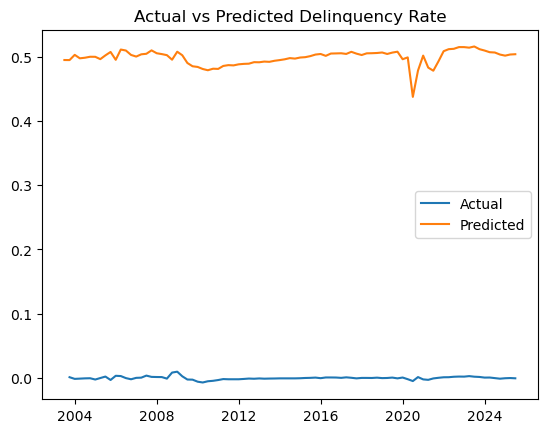

In [ ]:
## Plot fit

plt.figure()
plt.plot(df['Date'], df['Retail_Proxy_DR'], label='Actual')
plt.plot(df['Date'], df['pred_PD'], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Delinquency Rate")
plt.show()